# Model Exploration & Explanation

Now that we have a working model with a 96% accuracy, we'll look into explaining why and how the model works.

Guide:

- Feature importance
- Model Performance
- Feature Correlation

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import plot_confusion_matrix

from src.helper import praf1

import pickle

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load our data
df = pd.read_csv("../data/interim/data.csv")
train = pd.read_csv("../data/processed/train.csv")
test = pd.read_csv("../data/processed/test.csv")

In [3]:
# load in classifier and feature selector
with open("storage/gb-clf.pickle", "rb") as f:
    clf = pickle.load(f)
with open("storage/feat-select.pickle", "rb") as f:
    selector = pickle.load(f)

## Feature Importance

First on the agenda is identifying which features are important. We'll output the top 10

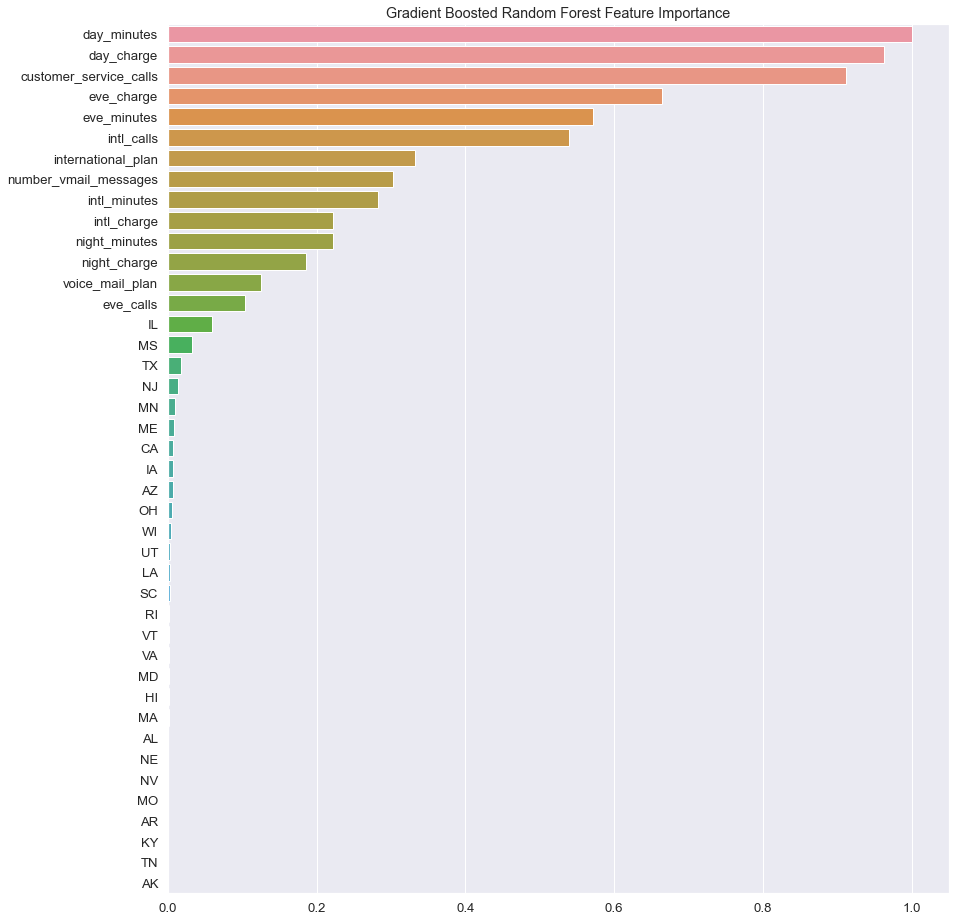

In [4]:
# get columns from feature selector and plot values
selected_feats = train.iloc[:, :-1].columns[selector.get_support()]
feat_impts = clf.feature_importances_
zipped = np.array(list(sorted(zip(selected_feats, feat_impts), key=lambda v: v[1], reverse=True)))

plt.figure(figsize=(14, 16))
sns.barplot(minmax_scale(zipped[:, 1]), zipped[:, 0]) # scaled our values to be in the range [0, 1]

plt.title("Gradient Boosted Random Forest Feature Importance")
plt.show()

Interestingly the most important features for determining whether a customer will soon stop doing business are the amount of minutes they've used during the day which is correlated with price aka their charge which is also another important feature. Along with that, the next most important feature is the amount of customer service calls they've placed, followed by their evening minutes used/ charge.

Looking into the reason why these features are important would be a great next step, but generally it may just be that customers as dissatisfied when their phone service bill is exceedingly large, and most importantly if an individual has to consistently call customer service for assistance they will become dissatisfied with the service provider,  

In [5]:
def fix_labels(string):
    return string.replace("_", " ").title()

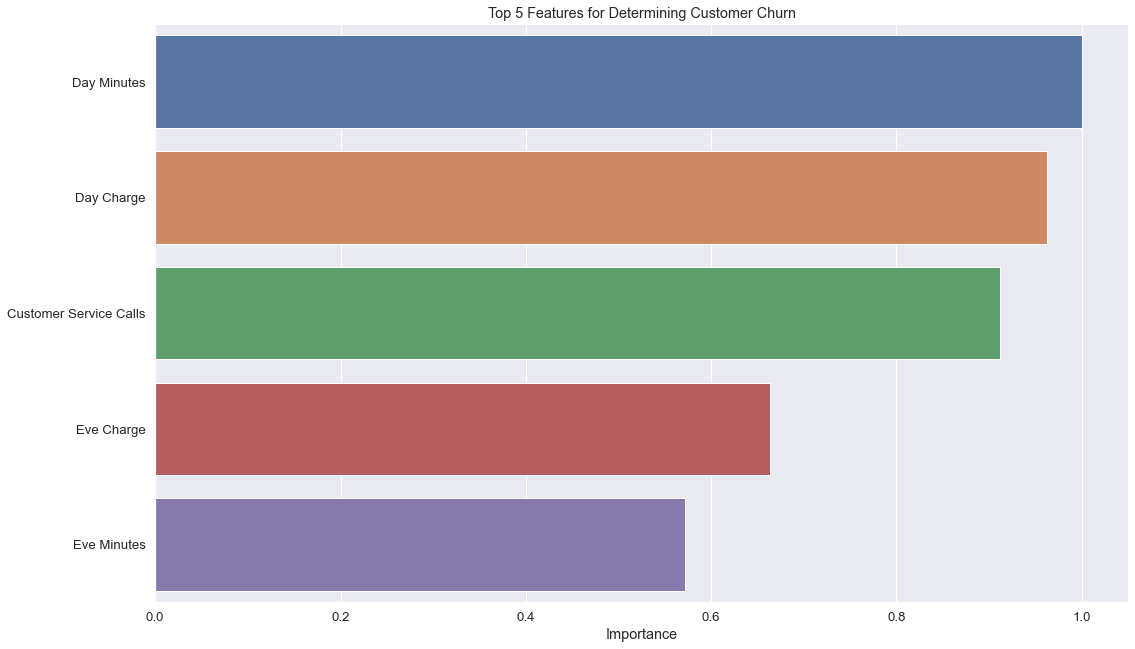

In [6]:
# output top 5 features
plt.figure(figsize=(16, 9))
labels = [fix_labels(i) for i in  zipped[:5, 0]]
sns.barplot(minmax_scale(zipped[:, 1])[:5], labels) # scaled our values to be in the range [0, 1]

plt.title("Top 5 Features for Determining Customer Churn")
plt.tight_layout()
plt.xlabel("Importance")

plt.savefig("../docs/visuals/01-top-5-features.svg", orientation="vertical")

plt.show()

## Model Performance

Our stakeholders will most likely want to know how our model performs. We'll give them a few of the descriptive metrics.

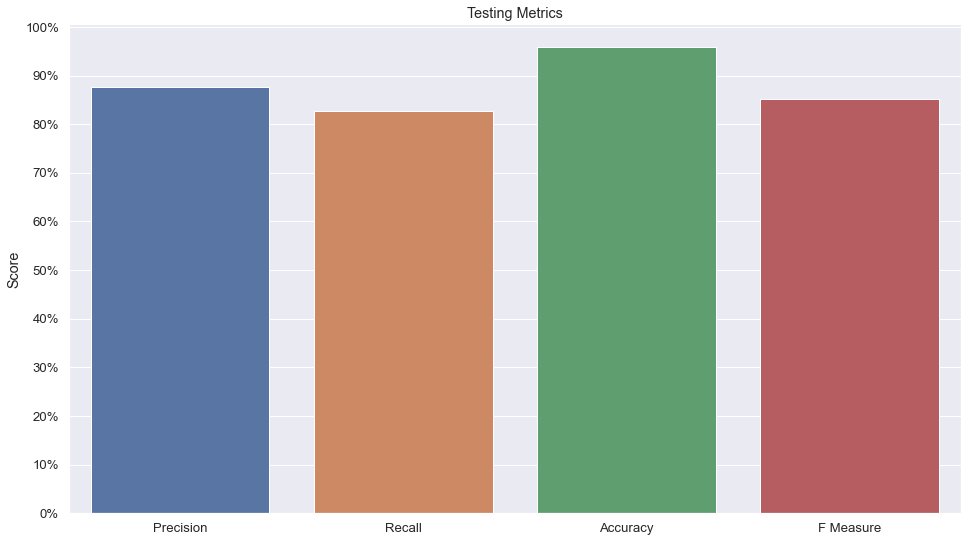

In [7]:
# get our testing results
X = selector.transform(test.iloc[:, :-1])
y = test.iloc[:, -1]

pred = clf.predict(X)

results = praf1(y, pred, "Test Results")

plt.figure(figsize=(16, 9))
sns.barplot(data=results)

ticks = np.linspace(0, 1, 11)
plt.yticks(ticks, [f"{i:.0%}" for i in ticks])

plt.title("Testing Metrics")
plt.ylabel("Score")
plt.xticks([0, 1, 2, 3], ["Precision", "Recall", "Accuracy", "F Measure"])

plt.savefig("../docs/visuals/02-model-testing-metrics.svg")

plt.show()

## Correlation of Features

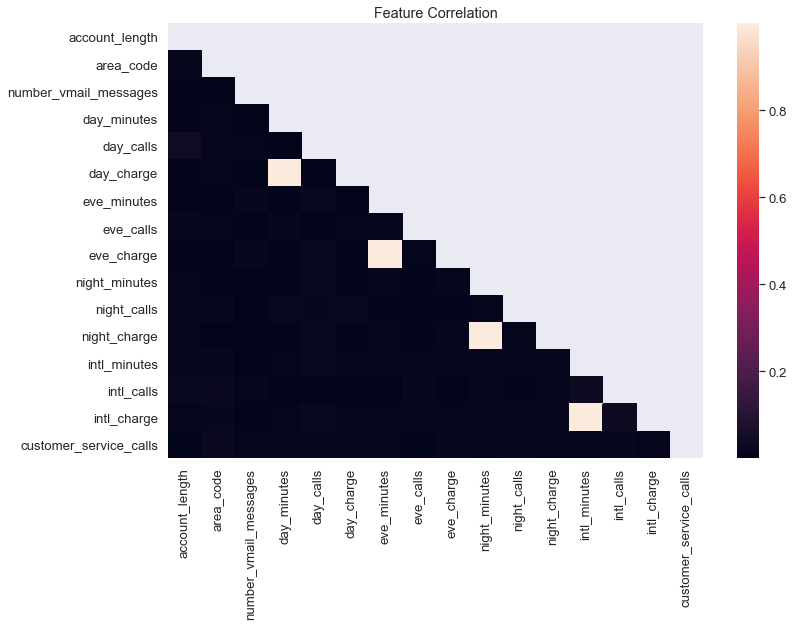

In [8]:
# correlation matrix of features

corr = np.abs(df.iloc[:, :-1].corr())
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask)

plt.title("Feature Correlation")

plt.show()

Practically all our features are independent of each other, however, our \*_charge features are perfectly correlated with our \*_minutes features

## Class Imbalance

In [9]:
# what percentage of customers are churning
vals = df[["churn", "state"]].groupby("churn").count()/df.shape[0]
vals

,state
churn,
False,0.855086
True,0.144914


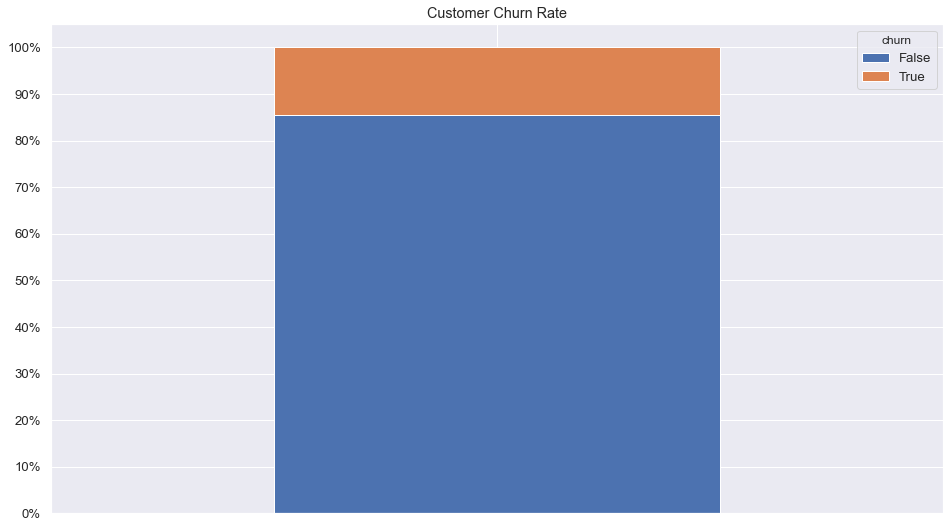

In [10]:
# output as stacked bar chart
fig, ax = plt.subplots(figsize=(16, 9))

vals.T.plot.bar(stacked=True, ax=ax)
plt.title("Customer Churn Rate")

plt.xticks([0], "")
plt.yticks(np.linspace(0, 1, 11), [f"{i:.0%}" for i in np.linspace(0, 1, 11)])

plt.savefig("../docs/visuals/03-customer-churn-rate.svg")
plt.show()

In the data given to us by our client we see that the customer churn rate is about 15%. As a business this is a size-able amount of customers to be losing consistently.